### Although mAP metric is popular, I think we still need to write a new notebook to compute CV score
1. Most of the mAP calculators are integrated within particular frameworks such as detectron2, yolo, mmdet, etc... It might lack flexibility if we want to ensemble various models.
2. Some standalone codes only compute box-mAP, not segm-mAP

=> So I reimplement the code to compute mAP for this competition. **Note that it only support single class at the moment**. I use my Detectron2 model to make predictions as an example and I also compare with Detectron2 built-in CocoEvaluator

In [1]:
from pathlib import Path
import random, cv2, os
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from tqdm.auto import tqdm
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import base64
from pycocotools import _mask as coco_mask
import typing as t
import zlib
import json
import torch

In [3]:
class CFG:
    
    MODEL_PATH = "/home/viktor/Documents/kaggle/hubmap-2023/experiments/mvp-segformer-norm2-bce-loss-no-augm/ckpts/segformer_epoch_99.pt"
    THRESHOLD = 0.32
    IMG_DIR = "/home/viktor/Documents/kaggle/hubmap-2023/kaggle-data/train"
    N_TRAIN = 1400 # Take first N_TRAIN images for training, rest for validation
    
    min_mask_area = 0 # minimum number of pixels of mask
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import json
from PIL import Image
from skimage.draw import polygon
from albumentations import Compose, Resize, HorizontalFlip, VerticalFlip, BboxParams
from torch.utils.data import Dataset, DataLoader


class HubmapDataset(Dataset):
        
    def __init__(self, image_dir, labels_file, n_train, mode='train'):
        
        assert mode in ['train', 'val'], "mode must be one of ['train', 'val']"
        self.mode = mode
        
        with open(labels_file, 'r') as json_file:
            self.json_labels = [json.loads(line) for line in json_file]

        if mode == 'train':
            self.json_labels = self.json_labels[:n_train]
        else:
            self.json_labels = self.json_labels[n_train:]

        self.image_dir = image_dir
        
        
        if mode == 'train':
            initial_augm = [
            
                
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                
                A.RandomBrightnessContrast(p=0.5, brightness_limit=0.2, contrast_limit=0.2),
                A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.1),
                A.CoarseDropout(max_holes=1, max_width=int(512 * 0.05), max_height=int(512 * 0.05), 
                                mask_fill_value=0, p=0.1),
                
                
                A.OneOf([
                        A.GaussNoise(var_limit=[10, 50]),
                        A.GaussianBlur(),
                        A.MotionBlur(),
                        ], p=0.1),
                A.MultiplicativeNoise(per_channel=True, multiplier=(0.95, 1.05)),
                
            ]
        else:
            initial_augm = []
        
        self.aug_list = initial_augm + [
                A.Resize(512, 512),
                A.Normalize(
                    mean= [0, 0, 0],
                    std= [1, 1, 1],
                    max_pixel_value = 255
                ),
                ToTensorV2(transpose_mask=True),
            ]
        
        # Create the augmentation pipeline
        self.augmentations = A.Compose(self.aug_list)

    def __len__(self):
        return len(self.json_labels)
        
    def __getitem__(self, idx):
        
        image_path = os.path.join(self.image_dir, f"{self.json_labels[idx]['id']}.tif")
        image = Image.open(image_path)
        
        
        # Get the mask
        mask = np.zeros((512, 512), dtype=np.float32)
        
        for annot in self.json_labels[idx]['annotations']:
            cords = annot['coordinates']
            if annot['type'] == "blood_vessel":
                for cord in cords:
                    rr, cc = polygon(np.array([i[1] for i in cord]), np.asarray([i[0] for i in cord]))
                    mask[rr, cc] = 1
                    
        image = np.array(image)

        # image = torch.tensor(np.array(image), dtype=torch.float32).permute(2, 0, 1)  # Shape: [C, H, W]
        # mask = torch.tensor(mask, dtype=torch.float32)


        augmented = self.augmentations(image=image, mask=mask)
        image, mask = augmented["image"], augmented["mask"]
        
        mean = torch.mean(image, dim=[1,2])
        std = torch.std(image, dim=[1,2])
        
        image = (image - mean[:, None, None]) / std[:, None, None]
        
        
        return image, mask


In [5]:
train_dataset = HubmapDataset(image_dir="/home/viktor/Documents/kaggle/hubmap-2023/kaggle-data/train", 
                              labels_file="/home/viktor/Documents/kaggle/hubmap-2023/kaggle-data/polygons.jsonl", 
                              n_train=CFG.N_TRAIN,
                              mode='train')

val_dataset = HubmapDataset(image_dir="/home/viktor/Documents/kaggle/hubmap-2023/kaggle-data/train", 
                              labels_file="/home/viktor/Documents/kaggle/hubmap-2023/kaggle-data/polygons.jsonl", 
                              n_train=CFG.N_TRAIN,
                              mode='val')

In [6]:
len(train_dataset), len(val_dataset)

(1400, 233)

In [7]:
from transformers import SegformerForSemanticSegmentation
import torch    
import torch.nn as nn

class Segformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.seg_model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b5",
                                                         num_labels=1,
                                                         ignore_mismatched_sizes=True,
                                                         num_channels=3)
        self.up = nn.Upsample(scale_factor=4, mode="bilinear")
        
    def forward(self, x):
        x = self.seg_model(x).logits
        x = self.up(x)
        return x



model = Segformer()


state_dict = torch.load(CFG.MODEL_PATH)
model.load_state_dict(state_dict)
model = model.to(CFG.device)


model = model.to(CFG.device)

Some weights of the model checkpoint at nvidia/mit-b5 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b5 and are newly initialized: ['decode_head.batch_norm.running_var', 'decode_head.classifier.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linea

In [8]:
# import segmentation_models_pytorch as smp

# model = smp.Unet(
#     encoder_name="mit_b5",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#     encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
#     in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#     classes=1,                      # model output channels (number of classes in your dataset)
# )

# state_dict = torch.load(CFG.MODEL_PATH)
# model.load_state_dict(state_dict)

# model = model.to(CFG.device)

In [9]:
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

def preprocess_img_for_model_inference(img_path):
    # image = cv2.imread(img_path)
    image = Image.open(img_path)
    
    image = np.array(image)
    
    
    # apply 
    aug_list = [
                A.Resize(512, 512),
                A.Normalize(
                    mean= [0, 0, 0],
                    std= [1, 1, 1],
                    max_pixel_value = 255
                ),
                ToTensorV2(transpose_mask=True),
            ]
        
   # Create the augmentation pipeline
    augmentations = A.Compose(aug_list)
    
    
    # image = torch.tensor(image).permute(2, 0, 1).unsqueeze(0).float()
    image = augmentations(image=image)["image"].unsqueeze(0)
    
    
    mean = torch.mean(image, dim=[1,2])
    std = torch.std(image, dim=[1,2])
    
    image = (image - mean[:, None, None]) / std[:, None, None]
    
    return image    

In [10]:
def seg_to_det(
    seg: np.ndarray, 
):
    num_outputs, labels, stats, centroids = cv2.connectedComponentsWithStats(seg)
    boxes = stats[:, [cv2.CC_STAT_LEFT, cv2.CC_STAT_TOP, cv2.CC_STAT_WIDTH, cv2.CC_STAT_HEIGHT]]
    label_masks = [labels == i for i in range(num_outputs)]
    dets = {
        "boxes": np.stack([
            boxes[:, 0],
            boxes[:, 1],
            boxes[:, 0] + boxes[:, 2],
            boxes[:, 1] + boxes[:, 3],
        ], axis=1),
        "masks": [seg * m for m in label_masks],
    }
    dets["scores"] = [np.max(seg[m]) for m in label_masks]
    
    # remove dets element where 'boxes' = [0, 0, 512, 512]
    boxes_to_remove = [0, 0, 512, 512]
    indices_to_remove = np.where(np.all(dets["boxes"] == boxes_to_remove, axis=1))
    
    dets["boxes"] = np.delete(dets["boxes"], indices_to_remove, axis=0)
    dets["masks"] = [i for j, i in enumerate(dets["masks"]) if j not in indices_to_remove]
    dets["scores"] = np.delete(dets["scores"], indices_to_remove)
    
    
    # remove dets where np.sum(mask) < CFG.min_mask_area
    indices_to_remove = []
    for i, mask in enumerate(dets["masks"]):
        if np.sum(mask) < CFG.min_mask_area:
            indices_to_remove.append(i)
            
    dets["boxes"] = np.delete(dets["boxes"], indices_to_remove, axis=0)
    dets["masks"] = [i for j, i in enumerate(dets["masks"]) if j not in indices_to_remove]
    dets["scores"] = np.delete(dets["scores"], indices_to_remove)
    
    return dets

def predict(image):
    with torch.no_grad():
        pred = model(image)
        pred = torch.sigmoid(pred)
        pred = pred.squeeze().cpu().numpy()
    
    
    pred = (pred > CFG.THRESHOLD).astype(np.uint8)*255
    dets = seg_to_det(pred)
    pred_masks, pred_classes, scores, boxes = dets["masks"], [0]*len(dets["masks"]), dets["scores"], dets["boxes"]
    
    # convert pred_masks to uint8_t
    pred_masks = [m.astype(np.uint8) for m in pred_masks]
    
    return pred_masks, pred_classes, scores, boxes

def predict_and_load_image(img_path):
    image = preprocess_img_for_model_inference(img_path)
    
    
    image = image.to(CFG.device)
    return predict(image)

## segm-mAP code

In [11]:
import pycocotools.mask as mask_util

In [12]:
def voc_ap(rec, prec):
    """
    --- Official matlab code VOC2012---
    mrec=[0 ; rec ; 1];
    mpre=[0 ; prec ; 0];
    for i=numel(mpre)-1:-1:1
            mpre(i)=max(mpre(i),mpre(i+1));
    end
    i=find(mrec(2:end)~=mrec(1:end-1))+1;
    ap=sum((mrec(i)-mrec(i-1)).*mpre(i));
    """
    rec.insert(0, 0.0) # insert 0.0 at begining of list
    rec.append(1.0) # insert 1.0 at end of list
    mrec = rec[:]
    prec.insert(0, 0.0) # insert 0.0 at begining of list
    prec.append(0.0) # insert 0.0 at end of list
    mpre = prec[:]
    """
     This part makes the precision monotonically decreasing
        (goes from the end to the beginning)
        matlab: for i=numel(mpre)-1:-1:1
                    mpre(i)=max(mpre(i),mpre(i+1));
    """
    # matlab indexes start in 1 but python in 0, so I have to do:
    #     range(start=(len(mpre) - 2), end=0, step=-1)
    # also the python function range excludes the end, resulting in:
    #     range(start=(len(mpre) - 2), end=-1, step=-1)
    for i in range(len(mpre)-2, -1, -1):
        mpre[i] = max(mpre[i], mpre[i+1])
    """
     This part creates a list of indexes where the recall changes
        matlab: i=find(mrec(2:end)~=mrec(1:end-1))+1;
    """
    i_list = []
    for i in range(1, len(mrec)):
        if mrec[i] != mrec[i-1]:
            i_list.append(i) # if it was matlab would be i + 1
    """
     The Average Precision (AP) is the area under the curve
        (numerical integration)
        matlab: ap=sum((mrec(i)-mrec(i-1)).*mpre(i));
    """
    ap = 0.0
    for i in i_list:
        ap += ((mrec[i]-mrec[i-1])*mpre[i])
    return ap, mrec, mpre


In [13]:
class MAPCalculatorSingleClass:
    def __init__(self, thresholds=[0.6]):
        self.ious = []
        self.confidences = []
        self.image_ids = []
        self.current_img_id = 0
        
        self.GT = 0
        
    def accumulate(self, ious, confidences, num_gt):
        assert len(ious) == len(confidences), f"ious and confidences must have same length: {len(ious)} != {len(confidences)}"
        self.ious.extend([x for x in ious])
        self.confidences.extend(confidences)
        self.image_ids.extend([self.current_img_id]*len(confidences))
        self.current_img_id += 1
        self.GT += num_gt
        
        
    def evaluate(self, thresholds=[0.6], vis=False):        
        # sort by confidence descending
        sorted_inds = np.argsort(self.confidences)[::-1]
        
        results = dict()
        
        for th in thresholds:
            accum_tp = 0
            accum_fp = 0
            
            TP = []
            FP = []
            list_gts = dict()
            
            NPREDS = []
            count = 0
            for ind in sorted_inds:
                iou_row = self.ious[ind]
                img_id = self.image_ids[ind]
                
                matched_inds = np.where(iou_row >= th)[0]
                best_gt_ind = -1
                best_iou = 0
                for gt_ind in matched_inds:
                    iou = iou_row[gt_ind]
                    if iou > best_iou and list_gts.get((img_id, gt_ind)) is None:
                        best_iou = iou
                        best_gt_ind = gt_ind
                
                if best_gt_ind != -1:
                    list_gts[(img_id, best_gt_ind)] = True
                    accum_tp += 1
                else:
                    accum_fp += 1
                    
                count += 1
                NPREDS.append(count)
                    
                TP.append(accum_tp)
                FP.append(accum_fp)
                
            PR = []
            REC = []
            
            for tp, fp in zip(TP, FP):
                pr = tp / (tp+fp+1e-5)
                rec = tp / self.GT
                PR.append(pr)
                REC.append(rec)
                
            if vis:
                plt.figure()
                plt.plot(REC, PR, '-o', label='precision-recall curve')
                
            ap, mrec, mpre = voc_ap(REC, PR)
            
            if vis:
                plt.plot(mrec, mpre, '--', label='interpolation')
                plt.legend()
                plt.title('Precision recall curve at threshold:'+str(np.round(th, 2)))
                plt.show()
            
            results[th] = ap
    
        outputs = {}
        outputs["true_positives"] = TP
        outputs["false_positives"] = FP
        outputs["precision"] = PR
        outputs["recall"] = REC
    
        return np.mean(list(results.values())), results, outputs

### Our custom code

In [34]:
mAP_calc = MAPCalculatorSingleClass()

pbar = enumerate(val_dataset)
pbar = tqdm(pbar, total=len(val_dataset))
    
areas_gt = []
areas_pred = []

heights_gt = []
heights_pred = []

widths_gt = []
widths_pred = []

aspect_ratios_gt = []
aspect_ratios_pred = []

for i, (images, target_masks) in pbar:
    
    
    width, height = images.shape[2], images.shape[1]
    images = images.unsqueeze(0).to(CFG.device)    
    
    dets = seg_to_det(target_masks.squeeze(0).cpu().numpy().astype(np.uint8)*255)
    target_masks, pred_classes, scores_target, bboxes_target = dets["masks"], [0]*len(dets["masks"]), dets["scores"], dets["boxes"]
    # convert pred_masks to uint8_t
    target_masks = [m.astype(np.uint8) for m in target_masks]

    # make prediction
    # pred_masks, pred_classes, scores = predict(predictor, img)
    pred_masks, pred_classes, scores_pred, bboxes_pred = predict(images)
    
    
    
    
    min_area = 5e4
    min_height = 5
    min_width = 5
    # # remove pred_masks with area < 200
    remove_inds = []
    for i, m in enumerate(pred_masks):
        if m.sum() < min_area or (bboxes_pred[i,3] - bboxes_pred[i,1] < min_height or bboxes_pred[i,2] - bboxes_pred[i,0] < min_width):
            remove_inds.append(i)
    pred_masks = [m for i, m in enumerate(pred_masks) if i not in remove_inds]
    pred_classes = [c for i, c in enumerate(pred_classes) if i not in remove_inds]
    scores_pred = [s for i, s in enumerate(scores_pred) if i not in remove_inds]
    bboxes_pred = bboxes_pred[~np.isin(np.arange(len(bboxes_pred)), remove_inds)]
    
    # remove_inds = []
    # for i, m in enumerate(target_masks):
    #     if m.sum() < min_area or (bboxes_target[i,3] - bboxes_target[i,1] < min_height and bboxes_target[i,2] - bboxes_target[i,0] < min_width):
    #         remove_inds.append(i)
    # target_masks = [m for i, m in enumerate(target_masks) if i not in remove_inds]
    # pred_classes = [c for i, c in enumerate(pred_classes) if i not in remove_inds]
    # scores_target = [s for i, s in enumerate(scores_target) if i not in remove_inds]
    # bboxes_target = bboxes_target[~np.isin(np.arange(len(bboxes_target)), remove_inds)]
    
    for i, m in enumerate(pred_masks):
        areas_pred.append(m.sum())
        
        height = bboxes_pred[i, 2] - bboxes_pred[i, 0]
        heights_pred.append(height)
        
        width = bboxes_pred[i, 3] - bboxes_pred[i, 1]
        widths_pred.append(width)
        
        aspect_ratio = width / height
        aspect_ratios_pred.append(aspect_ratio)
        
    
    for i, m in enumerate(target_masks):
        areas_gt.append(m.sum())
        
        height = bboxes_target[i, 2] - bboxes_target[i, 0]
        heights_gt.append(height)
        
        width = bboxes_target[i, 3] - bboxes_target[i, 1]
        widths_gt.append(width)
        
        aspect_ratio = width / height
        aspect_ratios_gt.append(aspect_ratio)
    
    
    
    
    
    # pred_masks: list of numpy array shape H*W 
    enc_preds = [mask_util.encode(np.asarray(p, order='F')) for p in pred_masks]
    enc_targs = [mask_util.encode(np.asarray(p, order='F')) for p in target_masks]
    
    num_gts = len(enc_targs)
    
    # calculate iou
    if len(enc_targs) > 0:
        ious = mask_util.iou(enc_preds, enc_targs, [0]*len(enc_targs))
    else:
        ious = np.array([[0]]*len(enc_preds))
    
    
    # acummulate predictions
    if num_gts > 0:
        mAP_calc.accumulate(ious, scores_pred, num_gts)
    

  0%|          | 0/233 [00:00<?, ?it/s]

In [35]:
mAP, detail_scores, outputs = mAP_calc.evaluate(thresholds=np.arange(0.5, 1.0, 0.05))
print('segm-mAP@0.5:0.95 by custom code:', mAP)

segm-mAP@0.5:0.95 by custom code: 0.15719817627585878


## Competition metric
- In this competition, the metric is segm-mAP@0.6

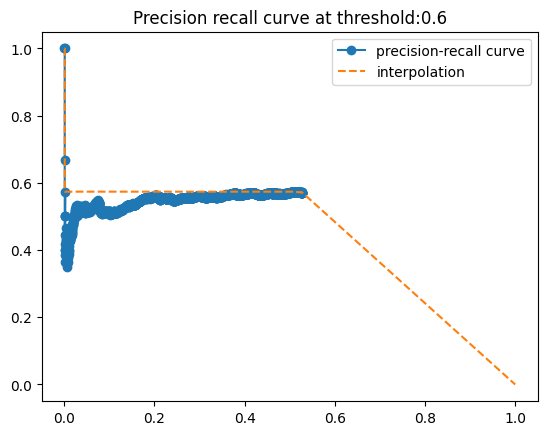

CV (mAP@0.6): 0.3033257465335569


In [36]:
# We test on the above dataset and get the CV score and visualize precision-recall curve
mAP, detail_scores, outputs = mAP_calc.evaluate(thresholds=[0.6], vis=True)
print('CV (mAP@0.6):', mAP)

min area: 0 -> CV (mAP@0.6): 0.2893773

<!-- 
min area: 2e4 -> CV (mAP@0.6): 0.33750069599634336


min area: 4e4 -> CV (mAP@0.6): 0.3515683621145983 -->


min area: 5e4 -> CV (mAP@0.6): 0.3033257465335569



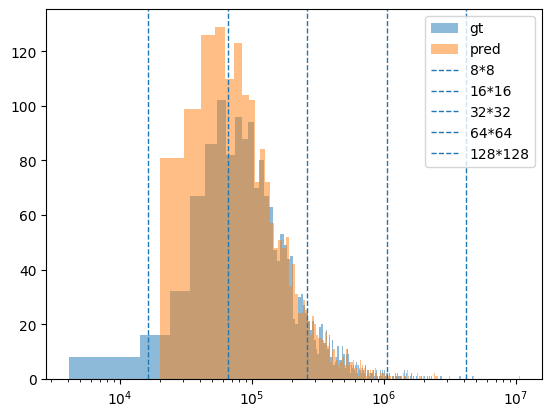

In [28]:
plt.hist(areas_gt, bins=1000, label='gt', alpha=0.5);
plt.hist(areas_pred, bins=1000, label='pred', alpha=0.5);

# set vertical line at 64*64
plt.axvline(255*8*8, linestyle='dashed', linewidth=1, label='8*8')
plt.axvline(255*16*16, linestyle='dashed', linewidth=1, label='16*16')
plt.axvline(255*32*32, linestyle='dashed', linewidth=1, label='32*32')
plt.axvline(255*64*64, linestyle='dashed', linewidth=1, label='64*64')
plt.axvline(255*128*128, linestyle='dashed', linewidth=1, label='128*128')

plt.xscale('log')

plt.legend()

Text(0.5, 0, 'height')

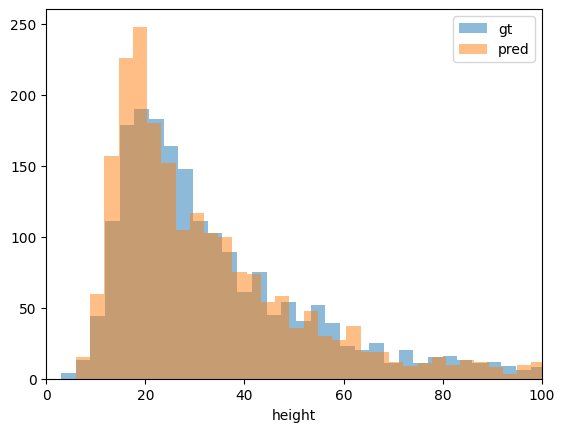

In [29]:
plt.hist(heights_gt, bins=100, label='gt', alpha=0.5);
plt.hist(heights_pred, bins=100, label='pred', alpha=0.5);

plt.xlim(0, 100)
plt.legend()
plt.xlabel('height')

Text(0.5, 0, 'width')

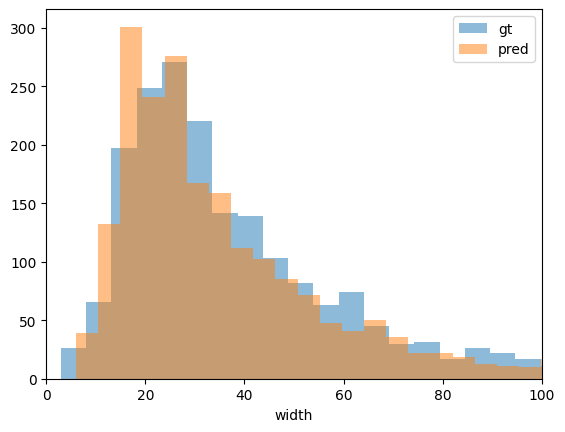

In [30]:
plt.hist(widths_gt, bins=100, label='gt', alpha=0.5);
plt.hist(widths_pred, bins=100, label='pred', alpha=0.5);

plt.xlim(0, 100)
plt.legend()
plt.xlabel('width')

Text(0.5, 0, 'aspect_ratio = width / height')

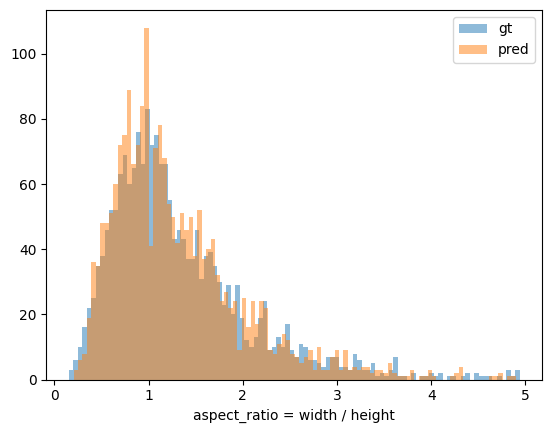

In [31]:
# remove nan from aspect_ratios_gt
aspect_ratios_gt = [a for a in aspect_ratios_gt if not np.isnan(a) and not np.isinf(a) and np.abs(a) < 5]
aspect_ratios_pred  = [a for a in aspect_ratios_pred if not np.isnan(a) and not np.isinf(a) and np.abs(a) < 5]

plt.hist(aspect_ratios_gt, bins=100, label='gt', alpha=0.5);
plt.hist(aspect_ratios_pred, bins=100, label='pred', alpha=0.5);

# plt.xlim(0, 2)
plt.legend()
plt.xlabel('aspect_ratio = width / height')

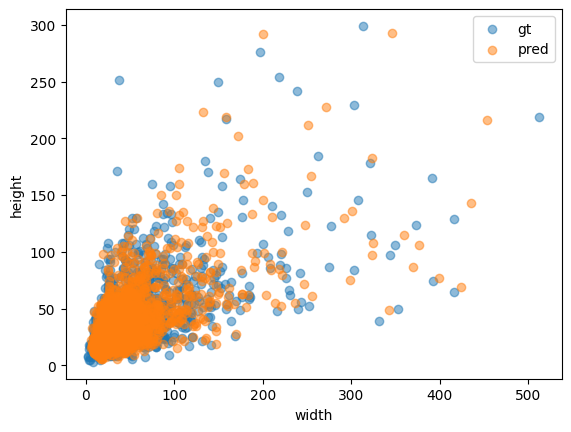

In [32]:
# scatter plot of width and height
plt.scatter(widths_gt, heights_gt, label='gt', alpha=0.5);
plt.scatter(widths_pred, heights_pred, label='pred', alpha=0.5);

plt.xlabel('width')
plt.ylabel('height')

plt.legend()

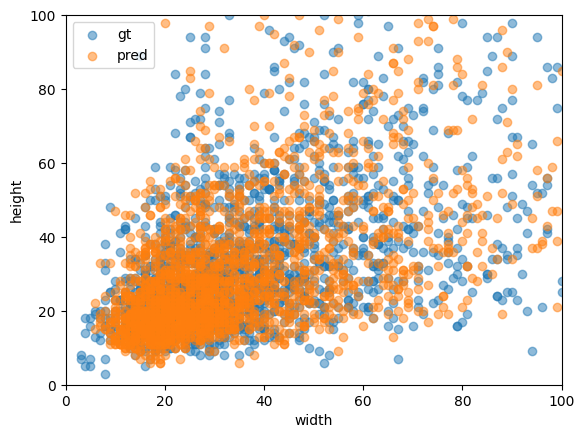

In [33]:
# scatter plot of width and height
plt.scatter(widths_gt, heights_gt, label='gt', alpha=0.5)
plt.scatter(widths_pred, heights_pred, label='pred', alpha=0.5)

# xlim 0 to 100
plt.xlim(0, 100)
plt.ylim(0, 100)

plt.xlabel('width')
plt.ylabel('height')

plt.legend()

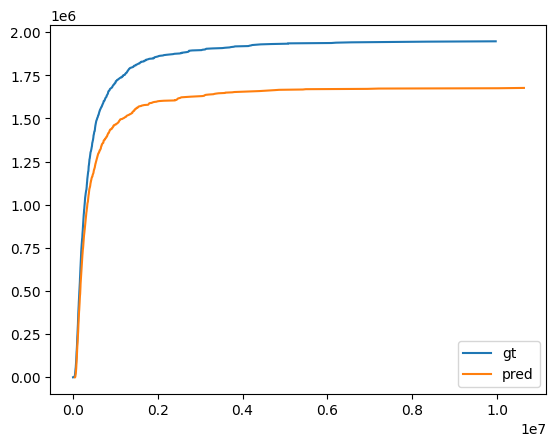

In [23]:
areas_gt = np.sort(areas_gt)
indices = np.arange(0, len(areas_gt), 1)
indices_cumsum = np.cumsum(indices)
plt.plot(areas_gt, indices_cumsum, label='gt')


areas_pred = np.sort(areas_pred)
indices = np.arange(0, len(areas_pred), 1)
indices_cumsum = np.cumsum(indices)

plt.plot(areas_pred, indices_cumsum, label='pred')

plt.legend()

/tmp/ipykernel_1471689/3341612647.py:5: RuntimeWarning: divide by zero encountered in divide
  indices_cumsum_diff = np.diff(indices_cumsum) / np.diff(areas_gt)
/tmp/ipykernel_1471689/3341612647.py:12: RuntimeWarning: divide by zero encountered in divide
  indices_cumsum_diff = np.diff(indices_cumsum) / np.diff(areas_pred)


(0.0, 2000000.0)

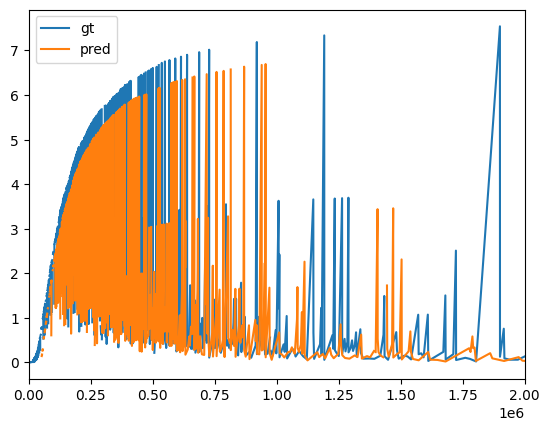

In [24]:
areas_gt = np.sort(areas_gt)
indices = np.arange(0, len(areas_gt), 1)
indices_cumsum = np.cumsum(indices)
# get derivative of indices_cumsum with respect to areas_gt
indices_cumsum_diff = np.diff(indices_cumsum) / np.diff(areas_gt)
plt.plot(areas_gt[:-1], indices_cumsum_diff, label='gt')


areas_pred = np.sort(areas_pred)
indices = np.arange(0, len(areas_pred), 1)
indices_cumsum = np.cumsum(indices)
indices_cumsum_diff = np.diff(indices_cumsum) / np.diff(areas_pred)
plt.plot(areas_pred[:-1], indices_cumsum_diff, label='pred')

plt.legend()
plt.xlim(0, 0.2e7)